In [1]:
import torch
from matplotlib import pyplot as plt

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import OptimalTransportSamplerConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig

from conditional_rate_matching.models.metrics.metrics_utils import MetricsAvaliable
from conditional_rate_matching.data.image_dataloader_config import NISTLoaderConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig

from conditional_rate_matching.models.temporal_networks.temporal_networks_config import TemporalUNetConfig
from conditional_rate_matching.models.temporal_networks.temporal_networks_config import CFMUnetConfig
from conditional_rate_matching.models.temporal_networks.temporal_networks_config import TemporalMLPConfig
from conditional_rate_matching.models.temporal_networks.temporal_networks_config import UConvNISTNetConfig
from conditional_rate_matching.models.temporal_networks.temporal_networks_config import DiffusersUnet2DConfig
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ExponentialThermostatConfig

# plots

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_pairing(x0,x1):
    # Assuming x0 and x1 are PyTorch tensors with shape (batch_size, 1, 28, 28)

    # Concatenate x0 and x1 horizontally (side by side)
    # This stacks along dimension 1 (channel dimension), since they are grayscale and have 1 channel.
    combined_images = torch.cat((x0, x1), dim=3)

    # Use make_grid to create a grid of images
    # We flatten the batch dimension with the height dimension to treat each pair as a separate image
    grid = make_grid(combined_images, nrow=1)  # nrow=1 to put all image pairs in one row for each batch

    # Plot the grid
    plt.figure(figsize=(6, 6))  # Adjust the size as needed
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')  # Permute the tensor to (Height, Width, Channels)
    plt.axis('off')  # Hide axes
    plt.show()

# call

In [3]:
def experiment_nist(number_of_epochs=300,
                    dataset_name="emnist",
                    berlin=True):
    crm_config = CRMConfig()
    crm_config.data0 = NISTLoaderConfig(flatten=True,as_image=False,batch_size=10,dataset_name="mnist",max_test_size=None)
    crm_config.data1 = NISTLoaderConfig(flatten=True,as_image=False,batch_size=10,dataset_name="mnist",max_test_size=None)
    crm_config.temporal_network = TemporalMLPConfig()

    crm_config.pipeline.number_of_steps = 12
    crm_config.trainer = CRMTrainerConfig(number_of_epochs=number_of_epochs,
                                          windows=berlin,
                                          metrics=[],
                                          max_test_size=200,
                                          learning_rate=1e-4)
    crm_config.trainer.debug = True
    crm_config.trainer.device = "cpu"
    return crm_config

In [4]:
config0 = experiment_nist(2,"emnist")
config1 = experiment_nist(2,"emnist")
config2 = experiment_nist(2,"emnist")

#config.trainer.metrics.append(MetricsAvaliable.loss_variance_times)

config1.optimal_transport = OptimalTransportSamplerConfig(name="OTPlanSampler",cost="log")
config2.optimal_transport = OptimalTransportSamplerConfig(name="OTPlanSampler",cost=None)

crm_l2 = CRM(config=config2)
crm_log = CRM(config=config1)
crm = CRM(config=config0)

In [5]:
crm_l2.config.optimal_transport

OptimalTransportSamplerConfig(name='OTPlanSampler', method='exact', cost=None, reg=0.05, reg_m=1.0, normalize_cost=False, warn=True)

In [6]:
databatch0 = next(crm.dataloader_0.train().__iter__())
databatch1 = next(crm.dataloader_1.train().__iter__())
x0 = databatch0[0]
x1 = databatch1[0]
batch_size = x1.shape[0]
x1 = torch.clone(x0)
x1 = x1[torch.randperm(batch_size)]
databatch1 = [x1]
time1 = torch.ones(x0.shape[0])

In [7]:
x1,x0 = crm.sample_pair(databatch1,databatch0,device=torch.device("cpu"))
x1_log,x0_log = crm_log.sample_pair(databatch1,databatch0,device=torch.device("cpu"))
x1_l2,x0_l2 = crm_l2.sample_pair(databatch1,databatch0,device=torch.device("cpu"))
batch_size = x1.shape[0]

x1 = x1.reshape(batch_size,1,28,28).detach()
x1_log = x1_log.reshape(batch_size,1,28,28).detach()
x1_l2 = x1_l2.reshape(batch_size,1,28,28).detach()

x0 = x0.reshape(batch_size,1,28,28).detach()
x0_l2 = x0_l2.reshape(batch_size,1,28,28).detach()
x0_log = x0_log.reshape(batch_size,1,28,28).detach()

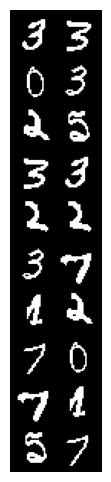

In [8]:
plot_pairing(x0,x1)

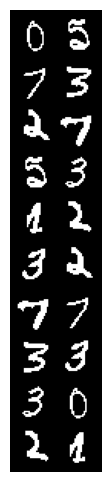

In [9]:
plot_pairing(x0_log,x1_log)